In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
def five_layer_model1(n=None):
    ''' 5layers, similar to Calamari?'''
    t5 = numpyro.sample("t5", dist.Uniform(2000, 3000))
    t1 = numpyro.sample("t1", dist.Uniform(0, 1000))
    t3 = numpyro.sample("t3", dist.Uniform(t1, t5))
    t2 = numpyro.sample("t2", dist.Uniform(t1, t3))
    t4 = numpyro.sample("t4", dist.Uniform(t3, t5))
    tarr = numpyro.deterministic("tarr", jnp.array([t5, t4, t3, t2, t1]))

def five_layer_model2(n=None):
    ''' 5 layers, starting from bottom '''
    t5 = numpyro.sample("t5", dist.Uniform(2000, 3000))
    t4 = numpyro.sample("t4", dist.Uniform(0, t5))
    t3 = numpyro.sample("t3", dist.Uniform(0, t4))
    t2 = numpyro.sample("t2", dist.Uniform(0, t3))
    t1 = numpyro.sample("t1", dist.Uniform(0, t2))
    tarr = numpyro.deterministic("tarr", jnp.array([t5, t4, t3, t2, t1]))

def n_layer_model(n):
    ''' generalization of five_layer_model2 to n layers '''
    t_bottom = numpyro.sample("t_bottom", dist.Uniform(2000, 3000))
    tratios = numpyro.sample("tratios", dist.Uniform(jnp.zeros(n-1), jnp.ones(n-1)))
    t_upper = t_bottom * jnp.cumprod(tratios)
    tarr = numpyro.deterministic("tarr", jnp.hstack([t_bottom, t_upper]))

"""
def n_layer_model_half(n):
    t_bottom = numpyro.sample("t_bottom", dist.Uniform(2000, 3000))
    tratios_lower = numpyro.sample("tratios_lower", dist.Uniform(jnp.zeros(n//2-1), jnp.ones(n//2-1)))
    tratios_upper = numpyro.sample("tratios_upper", dist.Uniform(jnp.zeros(n-n//2), jnp.ones(n-n//2)))
    t_lower_half = t_bottom * jnp.cumprod(tratios_lower)
    t_upper_half = t_lower_half[-1] * jnp.cumprod(tratios_upper)
    tarr = numpyro.deterministic("tarr", jnp.hstack([t_bottom, t_lower_half, t_upper_half]))
"""

def n_layer_model_equal(n):
    ''' a sort of generalization of five_layer_model1 to n layers '''
    t_bottom = numpyro.sample("t_bottom", dist.Uniform(2000, 3000))
    t_top = numpyro.sample("t_top", dist.Uniform(0, 1000))
    t_fracs_aug = numpyro.sample("t_fracs_aug", dist.Uniform(jnp.zeros(n), jnp.ones(n)))
    t_fracs = numpyro.deterministic("t_fracs", t_fracs_aug/jnp.sum(t_fracs_aug)) # sums to unity
    tarr = numpyro.deterministic("tarr", (t_top + jnp.cumsum(t_fracs) * (t_bottom - t_top))[::-1])

def get_parr(n):
    return np.linspace(-4, 2.5, n)[::-1]

def check_prior(model, n_layers):
    kernel = numpyro.infer.NUTS(model)
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=1000)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, n_layers)
    mcmc.print_summary()
    samples = mcmc.get_samples()['tarr']
    t_mean, t_sd = np.mean(samples, axis=0), np.std(samples, axis=0)

    np.random.seed(123)
    parr = get_parr(n_layers)
    plt.xlim(0, 3000)
    plt.ylim(2.5, -4)
    plt.xlabel("$T$")
    plt.ylabel("$\log P$")
    plt.plot(t_mean, parr, '.-', color='C0', label='posterior mean and SD')
    plt.fill_betweenx(parr, t_mean-t_sd, t_mean+t_sd, color='C0', alpha=0.2)
    for idx in np.random.randint(0, 1000, 20):
        plt.plot(samples[idx], parr, color='gray', lw=0.2)
    plt.legend(loc='best')
    #powers = np.arange(n_layers)
    #plt.plot(2500*2.**(-powers), parr, color='C1')

    return samples

### 5 layers, bottom -> top -> middle

sample: 100%|██████████| 2000/2000 [00:02<00:00, 786.33it/s, 7 steps of size 5.72e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        t1    503.73    279.81    491.28    119.98    987.24   1771.38      1.00
        t2   1008.66    508.51    945.50    187.84   1846.69   1556.34      1.00
        t3   1509.14    630.30   1495.68    457.79   2514.44   1470.65      1.00
        t4   2015.31    493.88   2052.53   1244.69   2815.79   1175.99      1.00
        t5   2508.15    301.92   2503.33   2049.19   2953.90   1694.33      1.00

Number of divergences: 0


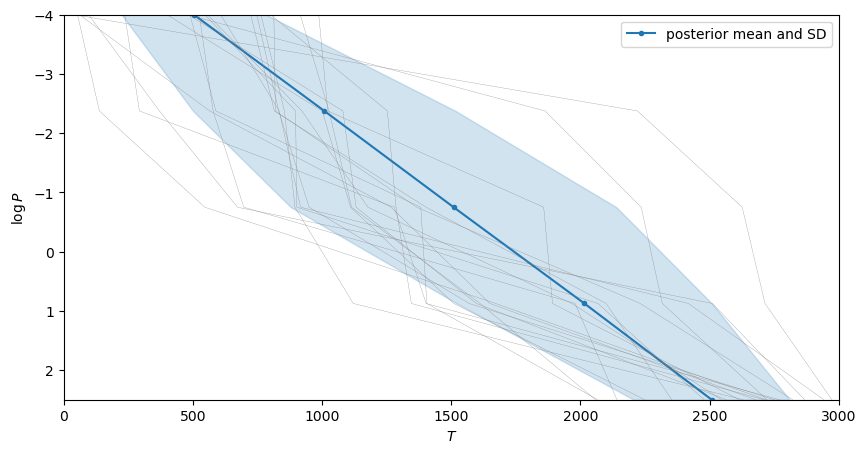

In [4]:
smp_five_1 = check_prior(five_layer_model1, 5)

### 5 layers, from bottom to top

sample: 100%|██████████| 2000/2000 [00:02<00:00, 798.82it/s, 7 steps of size 6.34e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        t1    151.86    219.84     61.46      0.00    415.21    747.56      1.00
        t2    313.02    373.40    173.13      0.13    814.46    822.90      1.00
        t3    622.69    573.55    465.47      0.75   1463.56    900.91      1.00
        t4   1242.98    750.72   1190.67     22.94   2310.65   1042.71      1.00
        t5   2509.29    301.10   2519.52   2022.76   2922.77   1371.09      1.00

Number of divergences: 0


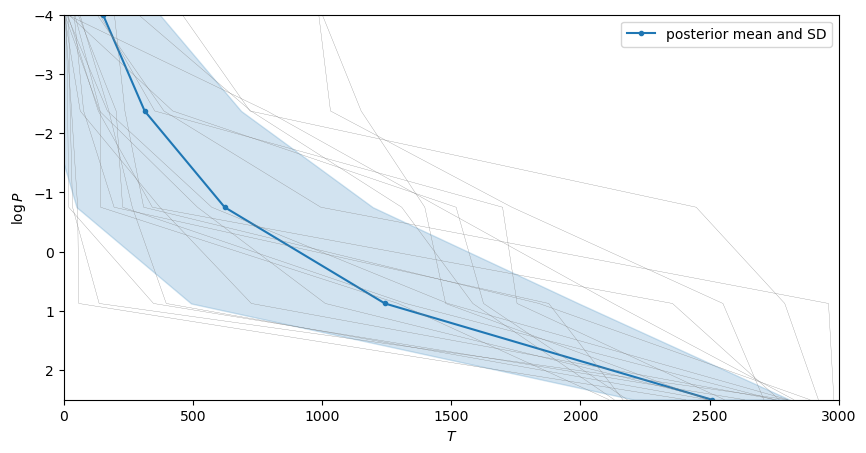

In [5]:
smp_five_2 = check_prior(five_layer_model2, 5)

### 10 layers, from bottom to top

sample: 100%|██████████| 2000/2000 [00:02<00:00, 949.16it/s, 7 steps of size 5.61e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  t_bottom   2505.92    283.09   2506.95   2114.16   2997.25   2634.22      1.00
tratios[0]      0.49      0.30      0.49      0.01      0.91   1865.92      1.00
tratios[1]      0.50      0.29      0.50      0.01      0.89   1887.24      1.00
tratios[2]      0.51      0.29      0.52      0.04      0.94   1817.30      1.00
tratios[3]      0.49      0.28      0.48      0.07      0.95   2211.99      1.00
tratios[4]      0.49      0.29      0.49      0.02      0.90   2477.69      1.00
tratios[5]      0.49      0.29      0.50      0.06      0.96   2211.98      1.00
tratios[6]      0.50      0.28      0.51      0.07      0.94   2497.02      1.00
tratios[7]      0.50      0.28      0.49      0.06      0.93   1698.58      1.00
tratios[8]      0.50      0.29      0.50      0.00      0.90   1490.56      1.00

Number of divergences: 0


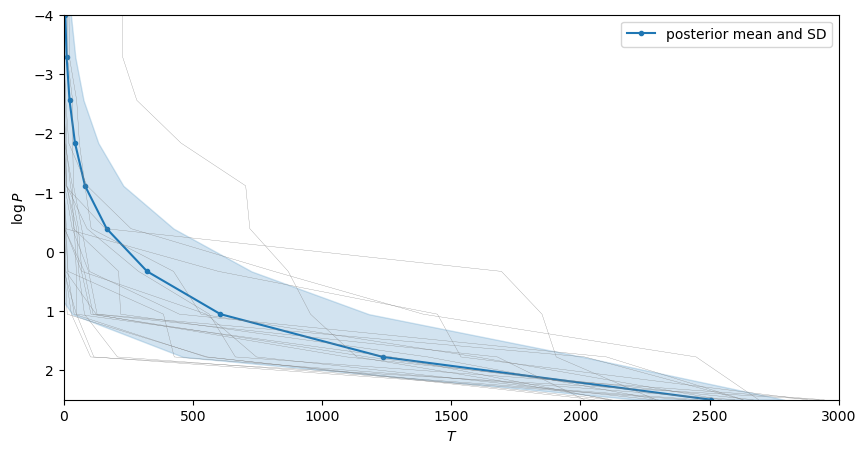

In [6]:
smp_10 = check_prior(n_layer_model, 10)

### 20 layers, from bottom to top

sample: 100%|██████████| 2000/2000 [00:02<00:00, 863.23it/s, 7 steps of size 5.06e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   t_bottom   2504.91    291.78   2509.40   2004.85   2906.45   1224.52      1.00
 tratios[0]      0.49      0.28      0.49      0.04      0.92   1695.94      1.00
 tratios[1]      0.51      0.29      0.51      0.02      0.90   2257.92      1.00
 tratios[2]      0.50      0.30      0.50      0.00      0.91   1725.97      1.00
 tratios[3]      0.49      0.29      0.49      0.03      0.92   2017.77      1.00
 tratios[4]      0.50      0.30      0.50      0.07      0.98   1301.48      1.00
 tratios[5]      0.49      0.29      0.49      0.05      0.94   1811.27      1.00
 tratios[6]      0.49      0.29      0.48      0.02      0.91   2044.01      1.00
 tratios[7]      0.50      0.29      0.50      0.08      0.96   1241.17      1.00
 tratios[8]      0.51      0.29      0.49      0.02      0.91   1922.44      1.00
 tratios[9]      0.50      0.29      0.50      0.09      1.00   1521.88      1.00
tratios[10]    

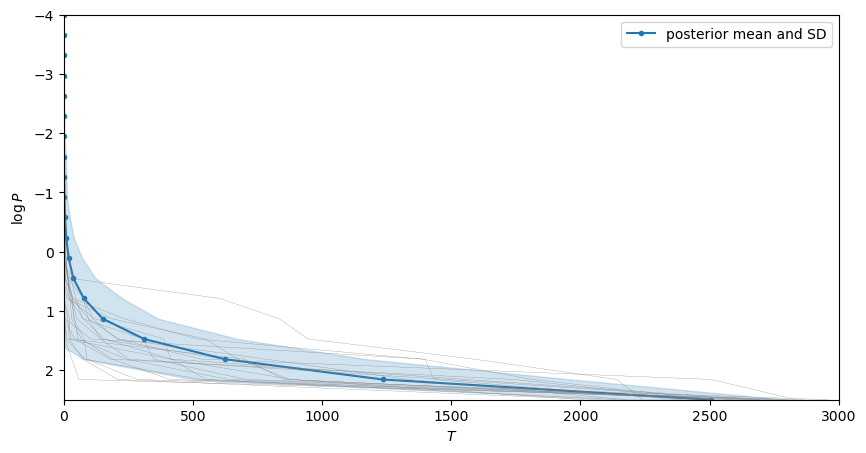

In [7]:
smp_20 = check_prior(n_layer_model, 20)

### 20 layers, equal fractions between bottom and top

sample: 100%|██████████| 2000/2000 [00:02<00:00, 851.94it/s, 7 steps of size 4.78e-01. acc. prob=0.88] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       t_bottom   2497.91    284.72   2506.96   2036.66   2910.93   1568.58      1.00
 t_fracs_aug[0]      0.49      0.29      0.49      0.01      0.89   1582.62      1.00
 t_fracs_aug[1]      0.50      0.29      0.49      0.10      1.00   1862.31      1.00
 t_fracs_aug[2]      0.52      0.27      0.52      0.10      0.95   1790.61      1.00
 t_fracs_aug[3]      0.50      0.30      0.50      0.05      0.95   1521.83      1.00
 t_fracs_aug[4]      0.49      0.28      0.49      0.02      0.90   1140.38      1.00
 t_fracs_aug[5]      0.50      0.29      0.50      0.00      0.90   2106.48      1.00
 t_fracs_aug[6]      0.50      0.30      0.50      0.02      0.92   1642.67      1.00
 t_fracs_aug[7]      0.50      0.28      0.51      0.03      0.90   1674.42      1.00
 t_fracs_aug[8]      0.50      0.29      0.50      0.11      1.00   1741.53      1.00
 t_fracs_aug[9]      0.51      0.27      0.52      0.

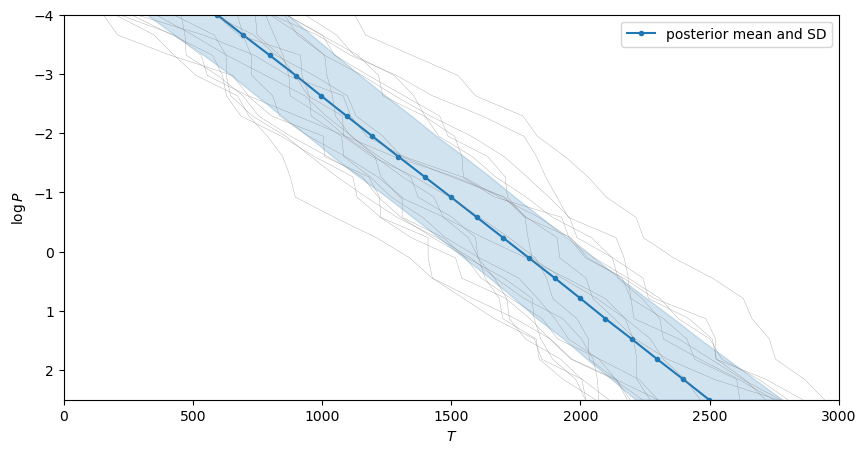

In [8]:
smp_20_equal = check_prior(n_layer_model_equal, 20)

### comparison

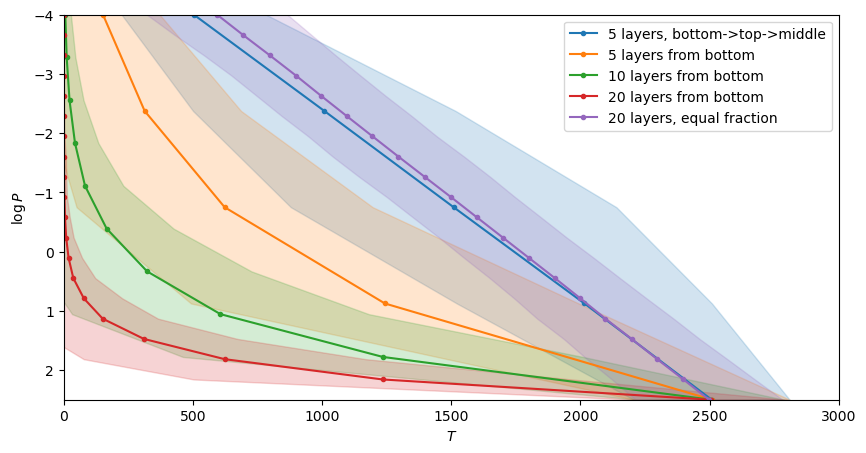

In [9]:
plt.xlim(0, 3000)
plt.ylim(2.5, -4)
plt.xlabel("$T$")
plt.ylabel("$\log P$")
for k, (samples, label, n) in enumerate(zip([smp_five_1, smp_five_2, smp_10, smp_20, smp_20_equal], ['5 layers, bottom->top->middle', '5 layers from bottom', '10 layers from bottom', '20 layers from bottom', 
                                                                                                '20 layers, equal fraction'], [5, 5, 10, 20, 20])):
    parr = get_parr(n)
    t_mean, t_sd = np.mean(samples, axis=0), np.std(samples, axis=0)
    plt.plot(t_mean, parr, '.-', color='C%d'%k, label=label)
    plt.fill_betweenx(parr, t_mean-t_sd, t_mean+t_sd, color='C%d'%k, alpha=0.2)
plt.legend(loc='best')